The universal workflow of DLWP 4.5 outlines the following steps, which I will be following using the CIFAR-10 dataset.

1. Define the problem and collect samples and labels
2. Choose the success criterion and monitoring metrics
3. Choose a validation protocol (hold-out...)
4. Prepare data
5. Develop a first underfitting model with statistical power
6. Develop a larger overfitting model
7. Regularize the overfitting model and tune hyperparameters based on your performance on validation data

## 1. Define the problem and collect samples and labels

#### What are you trying to predict?
We are trying to predict the class label given an input picture, which ranges from different vehicles to different animals.

#### Are the data (samples and labels) available?
Yes, in this project, we will be using the CIFAR-10 dataset which is a subset of the Tiny Images dataset and it consists of 60,000 32x32 colour images. There are 6,000 images per class with 5,000 training and 1,000 testing images per class.

The classes are as follows:

|Label|Description|
|---|---|
|0|Airplane
|1|Automobile
|2|Bird
|3|Cat
|4|Deer
|5|Dog
|6|Frog
|7|Horse
|8|Ship
|9|Truck

#### What is the type of problem?
This problem is single label multi-class problem, as there are only one class label for each input image, but there are a total of 10 different classes in total for the entire dataset.

This means that the last-layer activation method would be softmax, and the loss function will be calculated using categorical crossentropy.

## 2. Choose the success criterion and monitoring metrics

A successful model in this case would be one that is accurate in predicting the class label for a random unknown input image.

## 3. Choose a validation protocol (hold-out...)

Since the dataset is large with 60,000 samples, we will be using the hold-out method, where we would split the data set into a 60-20-20 ratio of train-test-validation sets.

## 4. Prepare data

In [1]:
# !pip install tensorflow -q
# !pip install tensorflow-datasets -q
# !pip install keras-tuner --upgrade -q

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds 
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
# returns np arrays of 50,000 train and 10,000 test items
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

The load_data() function returns a training set of 50,000 items and a test set of 10,000 items. These sets would be combined together in the next step so that we can further split them up into three different sets - train, test and validation, in the 3:1:1 ratio.

In [5]:
# combine the split train and test sets 
all_images = np.concatenate([train_images,test_images])
all_labels = np.concatenate([train_labels,test_labels])

In [6]:
# first split the set of all items into a 60% training and 40% test&validation set
x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, train_size=0.6, random_state=7)

# then, further split the 40% in 20% test and 20% validation set
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, train_size=0.5, random_state=7)

The shape of the images are read as follows: (number of samples, height, width, color channels). There are 3 colour channels as the pictures are coloured, and the colour channels represent the (R,G,B) values of each picture.

In [7]:
# check the shape of the six new array sets
# x arrays are uint8 NP arrays of image data with shapes
# y arrays are uint8 NP array of integer labels (from 0-9)

print("Train images", x_train.shape)
print("Train labels", y_train.shape)
print("-------")
print("Test images", x_test.shape)
print("Test labels", y_test.shape)
print("-------")
print("Validation images", x_val.shape)
print("Validation labels", y_val.shape)

Train images (36000, 32, 32, 3)
Train labels (36000, 1)
-------
Test images (12000, 32, 32, 3)
Test labels (12000, 1)
-------
Validation images (12000, 32, 32, 3)
Validation labels (12000, 1)


Display the first 10 items in the training set to visualize the dataset that we are working with.

In [8]:
import matplotlib.pyplot as plt

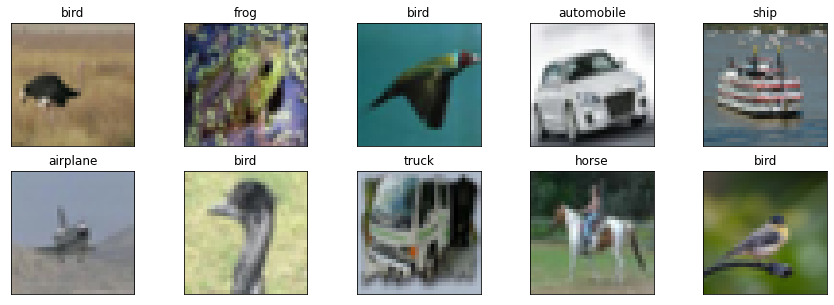

In [9]:
# labels of each of the 10 classes
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# show the first 10 items in the train set
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 5))

# initialize index to iterate the first 10 items of the sets
index = 0
for i in range(2):
    for j in range(5):
        axes[i,j].set_title(labels[y_train[index][0]])
        axes[i,j].imshow(x_train[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

## 5. Develop a first underfitting model with statistical power

We will first use the format of our dataset for the baseline model before normalizing the information.

A baseline model was developed to find the probability of accurately predicting the label of any unknown image. The baseline model will find the most frequently occured label in the training set, which in this case is a combination of training and validation set, and then use this label to predict the probability of a correct identification.

In [10]:
# initialize two arrays of zeros of length 10 (for all 10 categories) to count the total number of each class in each set
total_y_train_labels = np.zeros(10)
total_y_test_labels = np.zeros(10)

total_y_train = np.concatenate([y_train,y_val])

for i in range(len(total_y_train)):
    # counts 1 for every instance of the class that appears 
    
    # the number that is currently accessed will be [i] in the total_y_train set, and it will be an integer indicating which class it belongs to
    # accessing the total_y_train_labels array with total_y_train[i] allows us to access the class integer in the total_y_train_labels set
    total_y_train_labels[total_y_train[i]] += 1 
    
for i in range(len(y_test)):
    # counts 1 for every instance of the class that appears 
    total_y_test_labels[y_test[i]] +=1
    
print("The number of samples per class in training set:", total_y_train_labels)
print("Total number of samples in training set:", len(total_y_train))
print("----------")
print("The number of samples per class in test set:", total_y_test_labels)
print("Total number of samples in test set:", len(y_test))

The number of samples per class in training set: [4775. 4794. 4813. 4742. 4762. 4820. 4828. 4824. 4815. 4827.]
Total number of samples in training set: 48000
----------
The number of samples per class in test set: [1225. 1206. 1187. 1258. 1238. 1180. 1172. 1176. 1185. 1173.]
Total number of samples in test set: 12000


In [11]:
# find the class with the most instances
index_baseline = np.argmax(total_y_train_labels)

# find how accurate the model was in predicting the most populated class
accuracy_rate_baseline = total_y_test_labels[index_baseline]/len(y_test)

print("Most occrured class:", index_baseline)
print("Accuracy of baseline model:", round(accuracy_rate_baseline*100,2), "%")

Most occrured class: 6
Accuracy of baseline model: 9.77 %


### Assembling the data

The dataset would be converted into a neural network friendly format, so that it is easier for us to be training the model.

The images will be converted to grayscale to reduce the dimensionality of the data. This reduces the time taken to train the model. It can be easily done with the cv2 module.

In [12]:
import cv2

In [13]:
# convert all images to grayscale
x_train = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_train])
x_test = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_test])
x_val = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in x_val])

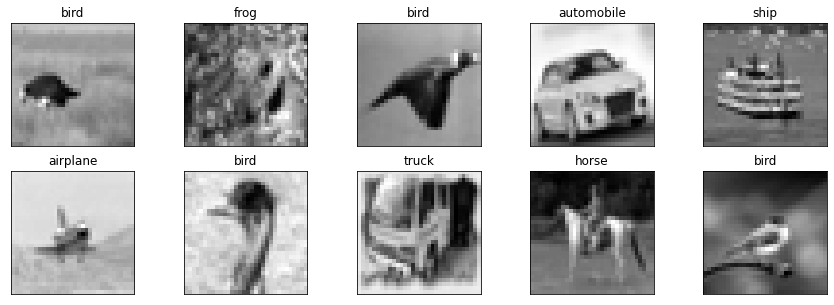

In [14]:
# show the first 10 items in the train set
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(15, 5))

# initialize index to iterate the first 10 items of the sets
index = 0
for i in range(2):
    for j in range(5):
        axes[i,j].set_title(labels[y_train[index][0]])
        axes[i,j].imshow(x_train[index], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

The array is being flattened into a 1D array of size 32x32 to accomodate all of the pixels present in all arrays. This means that all elements are being pushed into one single array.

In [15]:
x_train = x_train.reshape(36000,32*32)
x_test = x_test.reshape(12000,32*32)
x_val = x_val.reshape(12000,32*32)

Array values would also need to be normalized to be between a range of 0 to 1, which will be easier for the neural network to work with. Since pixel brightness values are usually between a range of 0 to 255, we would divide the array by 255 to achieve values between a range of 0 to 1.

In [16]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
x_val = x_val.astype('float32')/255

The labels are still in an array with an integer value between 0 to 9 to represent the different classes. These labels should be in a one-hot representation in order to be used in our neural network. This can be done using the OneHotEncoder module.

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
# initialize oneHotEncoder, and set sparse to false so we it will return an array instead of a matrix
oneHotEncoder = OneHotEncoder(sparse=False)

# fit oneHotEncoder to y to determine each class that is present
oneHotEncoder.fit(all_labels)

# transform all y arrays to oneHotEncoding format
y_train = oneHotEncoder.transform(y_train)
y_test = oneHotEncoder.transform(y_test)
y_val = oneHotEncoder.transform(y_val)

In [19]:
# check the shape of the six new array sets
# x arrays are uint8 NP arrays of image data with shapes
# y arrays are uint8 NP array of integer labels (from 0-9)

print("Train images", x_train.shape)
print("Train labels", y_train.shape)
print("-------")
print("Test images", x_test.shape)
print("Test labels", y_test.shape)
print("-------")
print("Validation images", x_val.shape)
print("Validation labels", y_val.shape)

Train images (36000, 1024)
Train labels (36000, 10)
-------
Test images (12000, 1024)
Test labels (12000, 10)
-------
Validation images (12000, 1024)
Validation labels (12000, 10)


## 6. Develop a larger overfitting model

Here are two general plot graph functions that we can easily call and reuse to draw out the loss and accuracy results of any model we will be using.

In [20]:
def plotLoss(loss, val_loss):
    # clears any current figure to start a new drawing
    plt.clf()
    # gets the number of epochs that were used so that we are able to plot the axes
    epochs = range(1, len(loss)+1)
    
    # plot the data
    plt.plot(epochs, loss, 'mo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'co-', label='Validation Loss')
    
    # legend
    plt.title("Training Loss and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [21]:
def plotAccuracy(acc, val_acc):
    plt.clf()
    epochs = range(1, len(acc)+1)
    
    plt.plot(epochs, acc, 'mo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'co-', label='Validation Accuracy')
    
    plt.title("Training Accuracy and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

### Underfitting model

We would first develop a simple model with only the required last layer, with the minimum requirement of having an accuracy higher than 0.1. The last layer output should be equal to the number of classes we are trying to classify.

We are developing an underfitting model so that it could be used as a baseline to compare against other models, and ultimately to find a middle ground where the model is neither over or underfitted.

The Adam optimizer is an algorithm used in deep learning that updates the model's parameters during training. It is mostly used for gradient-based optimization models, where it calculates adaptive learning rates for each parameter based on the first and second moments of the gradients. This means that it is able to dynamically adjust the learning rate during training.

In [22]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [23]:
underModel = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(1024,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [24]:
underModel.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [25]:
underModelResult = underModel.fit(x_train, y_train, epochs=10, batch_size=32,
                    validation_split=0.2)

Epoch 1/10
900/900 [==============================] - 13s 13ms/step - loss: 2.0914 - accuracy: 0.2439 - val_loss: 2.0457 - val_accuracy: 0.2539
Epoch 2/10
900/900 [==============================] - 11s 13ms/step - loss: 1.9676 - accuracy: 0.3032 - val_loss: 1.9324 - val_accuracy: 0.3194
Epoch 3/10
900/900 [==============================] - 12s 13ms/step - loss: 1.9021 - accuracy: 0.3332 - val_loss: 1.8915 - val_accuracy: 0.3269
Epoch 4/10
900/900 [==============================] - 12s 13ms/step - loss: 1.8527 - accuracy: 0.3507 - val_loss: 1.8466 - val_accuracy: 0.3397
Epoch 5/10
900/900 [==============================] - 12s 13ms/step - loss: 1.8126 - accuracy: 0.3651 - val_loss: 1.8168 - val_accuracy: 0.3571
Epoch 6/10
900/900 [==============================] - 12s 14ms/step - loss: 1.7786 - accuracy: 0.3759 - val_loss: 1.7946 - val_accuracy: 0.3619
Epoch 7/10
900/900 [==============================] - 12s 13ms/step - loss: 1.7469 - accuracy: 0.3889 - val_loss: 1.7600 - val_accuracy:

In [26]:
underModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               524800    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 591,754
Trainable params: 591,754
Non-trainable params: 0
_________________________________________________________________


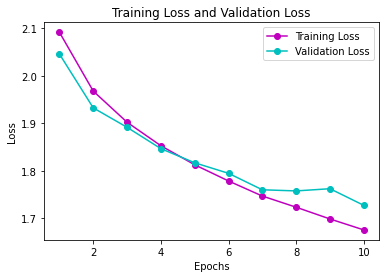

In [27]:
plotLoss(underModelResult.history['loss'], underModelResult.history['val_loss'])

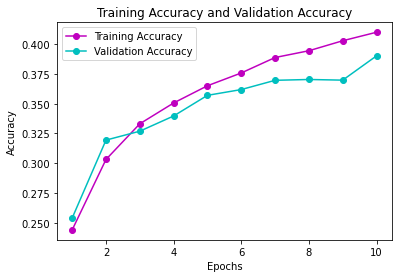

In [28]:
plotAccuracy(underModelResult.history['accuracy'], underModelResult.history['val_accuracy'])

In [29]:
test_loss_underModel, test_acc_underModel = underModel.evaluate(x_val, y_val)
print('Test accuracy:', round(test_acc_underModel*100,2), "%")

375/375 [==============================] - 3s 7ms/step - loss: 1.7276 - accuracy: 0.3887
Test accuracy: 38.87 %


### Overfitting model

In [30]:
overModel = models.Sequential([
    layers.Dense(1024, activation='relu', input_shape=(1024,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [31]:
overModel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
overModelResult = overModel.fit(x_train, y_train, epochs=40, batch_size=32,
                    validation_split=0.2)

Epoch 1/40
900/900 [==============================] - 38s 37ms/step - loss: 2.1167 - accuracy: 0.2126 - val_loss: 2.0278 - val_accuracy: 0.2440
Epoch 2/40
900/900 [==============================] - 33s 37ms/step - loss: 1.9608 - accuracy: 0.2922 - val_loss: 1.9275 - val_accuracy: 0.3040
Epoch 3/40
900/900 [==============================] - 33s 37ms/step - loss: 1.9087 - accuracy: 0.3125 - val_loss: 1.9118 - val_accuracy: 0.3175
Epoch 4/40
900/900 [==============================] - 33s 37ms/step - loss: 1.8641 - accuracy: 0.3325 - val_loss: 1.9087 - val_accuracy: 0.2981
Epoch 5/40
900/900 [==============================] - 34s 37ms/step - loss: 1.8330 - accuracy: 0.3432 - val_loss: 1.9042 - val_accuracy: 0.3232
Epoch 6/40
900/900 [==============================] - 33s 37ms/step - loss: 1.7896 - accuracy: 0.3590 - val_loss: 1.8122 - val_accuracy: 0.3471
Epoch 7/40
900/900 [==============================] - 34s 38ms/step - loss: 1.7587 - accuracy: 0.3713 - val_loss: 1.7777 - val_accuracy:

In [33]:
overModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_4 (Dense)             (None, 512)               524800    
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 10)               

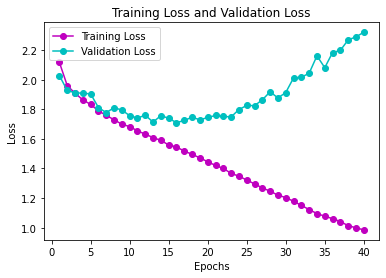

In [34]:
plotLoss(overModelResult.history['loss'], overModelResult.history['val_loss'])

For the validation loss, it was decreasing steadily before starting to increase again aroun the 10th epoch mark. This shows where the model was starting to overfit around the training dataset, learning all the noise and insignificant values that are not helpful in determining the pattern in the dataset. Overfitting on the training set results in the model doing poorly on unseen data, which is the validation set in this case.

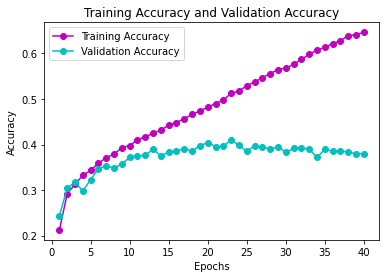

In [35]:
plotAccuracy(overModelResult.history['accuracy'], overModelResult.history['val_accuracy'])

The accuracy of the validation set can also be seen increasing with training, before remaining stagnant at around the 15th epoch mark. This also shows the result of the model overfitting on training data and how it affects the model on new unseen data.

In [36]:
test_loss_overModel, test_acc_overModel = overModel.evaluate(x_val, y_val)
print('Test accuracy:', round(test_acc_overModel*100,2), "%")

375/375 [==============================] - 3s 8ms/step - loss: 2.3651 - accuracy: 0.3826
Test accuracy: 38.26 %


#### Underfitted vs overfitted model 

The underfitting model has performed slightly better at 38.87% than the overfitting model at 38.26%, likely due to the overfitting model undergoing extensive training on the training set. 

The extensive training causes the overfitting model to learn the noise and the random fluctuations in the training data, and is unable to spot any underlying patterns. This was also likely due to the larger number of epochs and batch sizes in the training model, leading to a more complext model, which enabled the model to learn more about the training set in detail.

Thus, the overfitting model performed poorly on new data as the model is fixated on the noise and randomness pattern it has picked up on from the training set, which is not present in the test data.

### Visually comparing both underfitted and overfitted model

In [37]:
def plotComparison(plot1, plot2, plotType):
    line1 = plot1
    line2 = plot2

    plt.clf()
    
    # create two empty plots to draw the two different graphs together
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    # set the range for the axes
    epochs1 = range(1, len(line1)+1)
    epochs2 = range(1, len(line2)+1)

    # set the labelling for the different graphs
    ax.plot(epochs1, line1, 'bo-')
    ax.set_xlabel("Epochs", color="b")
    ax.set_ylabel("Underfitted " + plotType, color="b")

    # set the position of the second graph to the on the top and right corner
    # so that it does not overlap with the first graph
    ax2.plot(epochs2, line2, 'yo-')
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax2.set_xlabel("Epochs", color="y")
    ax2.set_ylabel("Overfitted " + plotType, color="y")
    ax2.xaxis.set_label_position('top') 
    ax2.yaxis.set_label_position('right')


    plt.title(plotType + " Under VS Over fitted")
    plt.grid()
    plt.show()

#### Training loss in both the underfitted and overfitted model

<Figure size 432x288 with 0 Axes>

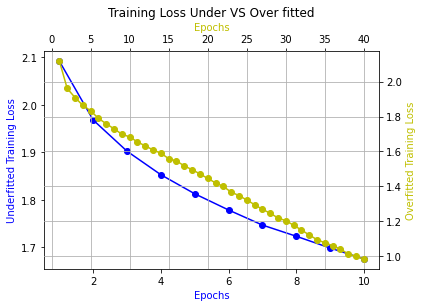

In [38]:
plotComparison(underModelResult.history['loss'], overModelResult.history['loss'], "Training Loss")

The training loss for both models are constant in showing that with training, the model learns better and produces more accurate results, as seen with a lower loss rate.

#### Training accuracy in both the underfitted and overfitted model

<Figure size 432x288 with 0 Axes>

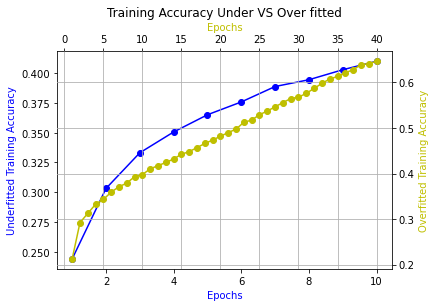

In [39]:
plotComparison(underModelResult.history['accuracy'], overModelResult.history['accuracy'], "Training Accuracy")

The training accuracy for both models are also constant in showing that the results are more accurate with more training done, as seen with the higher accuracy rate.

#### Validation loss in both the underfitted and overfitted model

<Figure size 432x288 with 0 Axes>

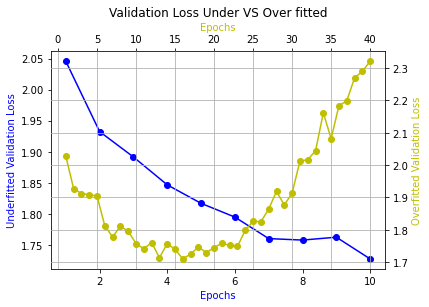

In [40]:
plotComparison(underModelResult.history['val_loss'], overModelResult.history['val_loss'], "Validation Loss")

The validation loss shows the effect of the test set on the trained model, and we can see that for the underfitted model, the validation set stil produces reasonable loss drop rates with the number of epochs increasing. 

However for the overfitted model, it can be seen that the loss has descreased before taking a turn and steadily increases as the number of epochs increase. This is due to the model being too overfitted on the training data and not being able to determine a working pattern between the variables. This causes the model to perform poorly on the validation set, which can be seen here with the increase of loss value after approximately the 15th epoch.

#### Validation accuracy in both the underfitted and overfitted model

<Figure size 432x288 with 0 Axes>

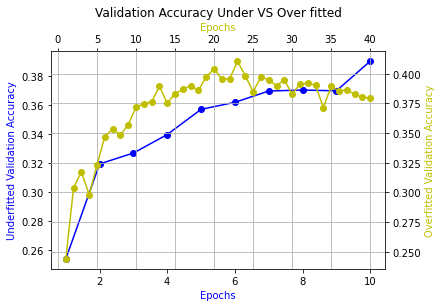

In [41]:
plotComparison(underModelResult.history['val_accuracy'], overModelResult.history['val_accuracy'], "Validation Accuracy")

Overfitting can also be seen here in this diagram where the constant increase of validation accuracy suddenly decreases and stays somewhat stagnant over a small range. This shows that the model is overfitted on the training data and no longer generalizes well on unseen data, and thus unable to make accurate predictions.

For the underfitted validation accuracy, the accuracy rate steadily increases as the number of epoch increases, which is a good pattern to ensure that the model is not too reliant on the training data.

## 7. Regularize the overfitting model and tune hyper parameters based on performance on validation data

After having a overfitting model, we must now tune the model so that it is more generalized and is able to work well on unseen data.

### Method 1: Removing layers 

Removing the number of layers ensure that the model is not too complex, preventing the model from capturing specific patterns from the data, causing it to overfit.

We must also becareful not to remove too many layers else it might result in the model underfitting due to not having enough data.

In [42]:
model1 = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(1024,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [43]:
model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [44]:
model1Result = model1.fit(x_train, y_train, epochs=40, batch_size=32,
                    validation_split=0.2)

Epoch 1/40
900/900 [==============================] - 20s 19ms/step - loss: 2.0757 - accuracy: 0.2380 - val_loss: 1.9508 - val_accuracy: 0.2901
Epoch 2/40
900/900 [==============================] - 16s 18ms/step - loss: 1.9229 - accuracy: 0.3109 - val_loss: 1.8804 - val_accuracy: 0.3182
Epoch 3/40
900/900 [==============================] - 16s 18ms/step - loss: 1.8550 - accuracy: 0.3383 - val_loss: 1.8458 - val_accuracy: 0.3299
Epoch 4/40
900/900 [==============================] - 17s 19ms/step - loss: 1.7985 - accuracy: 0.3570 - val_loss: 1.7766 - val_accuracy: 0.3567
Epoch 5/40
900/900 [==============================] - 17s 19ms/step - loss: 1.7672 - accuracy: 0.3719 - val_loss: 1.8143 - val_accuracy: 0.3447
Epoch 6/40
900/900 [==============================] - 17s 19ms/step - loss: 1.7312 - accuracy: 0.3870 - val_loss: 1.7752 - val_accuracy: 0.3635
Epoch 7/40
900/900 [==============================] - 16s 18ms/step - loss: 1.7005 - accuracy: 0.3951 - val_loss: 1.7535 - val_accuracy:

In [45]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 10)                1290      
                                                                 
Total params: 690,314
Trainable params: 690,314
Non-trainable params: 0
_________________________________________________________________


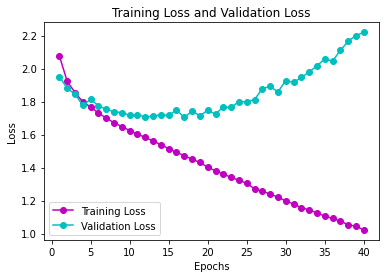

In [46]:
plotLoss(model1Result.history['loss'], model1Result.history['val_loss'])

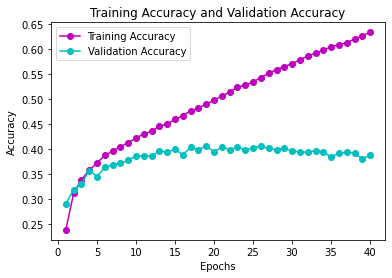

In [47]:
plotAccuracy(model1Result.history['accuracy'], model1Result.history['val_accuracy'])

In [48]:
test_loss1, test_acc1 = model1.evaluate(x_val, y_val)
print('Test accuracy:', round(test_acc1*100,2), "%")

375/375 [==============================] - 4s 10ms/step - loss: 2.2461 - accuracy: 0.3842
Test accuracy: 38.42 %


#### Removing layers vs under and overfitted model

The new model with lesser layers than the overfitted model, and more layers than the underfitted model has performed better than the overfitted model, which was at a 38.26% accuracy, with a 38.42% accuracy. However, it did worse than the underfitted model which rated at 38.87% accuracy. 

Different number of layers were tested and having four layers in this scenario seemed to be the most ideal.

This shows that reducing the number of layers does help improve the model, and more experiment can be carried out to find the optimal number of layers.

### Method 2: Adding dropout

Adding dropout is another method to prevent overfitting. The dropout function randomly drops out a fraction of the neurons in a layer during each training iteration. 

This ensures that the model learns to be more robust and less reliant on the specific patterns in the training data. This ensures that the model can generalize on new unseen data.

In [49]:
model2 = models.Sequential([
    layers.Dense(1024, activation='relu', input_shape=(1024,)),
    layers.Dropout(0.1),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [50]:
model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
model2Result = model2.fit(x_train, y_train, epochs=40, batch_size=32,
                    validation_split=0.2)

Epoch 1/40
900/900 [==============================] - 37s 37ms/step - loss: 2.1560 - accuracy: 0.1922 - val_loss: 2.0630 - val_accuracy: 0.2569
Epoch 2/40
900/900 [==============================] - 33s 36ms/step - loss: 2.0293 - accuracy: 0.2633 - val_loss: 2.0285 - val_accuracy: 0.2393
Epoch 3/40
900/900 [==============================] - 33s 36ms/step - loss: 1.9664 - accuracy: 0.2863 - val_loss: 1.9564 - val_accuracy: 0.2886
Epoch 4/40
900/900 [==============================] - 33s 37ms/step - loss: 1.9249 - accuracy: 0.3020 - val_loss: 1.8805 - val_accuracy: 0.3232
Epoch 5/40
900/900 [==============================] - 33s 36ms/step - loss: 1.8955 - accuracy: 0.3156 - val_loss: 1.8473 - val_accuracy: 0.3269
Epoch 6/40
900/900 [==============================] - 33s 36ms/step - loss: 1.8728 - accuracy: 0.3242 - val_loss: 1.8476 - val_accuracy: 0.3343
Epoch 7/40
900/900 [==============================] - 33s 37ms/step - loss: 1.8423 - accuracy: 0.3367 - val_loss: 1.8264 - val_accuracy:

In [52]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1024)              1049600   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 64)               

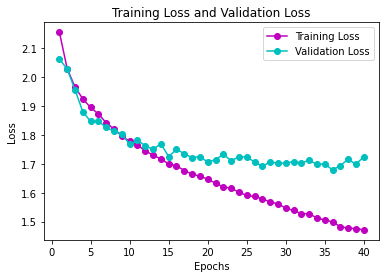

In [53]:
plotLoss(model2Result.history['loss'], model2Result.history['val_loss'])

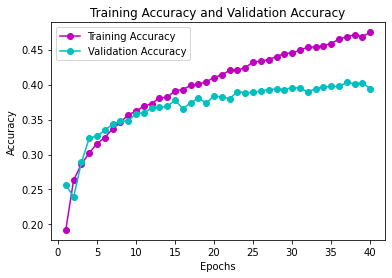

In [54]:
plotAccuracy(model2Result.history['accuracy'], model2Result.history['val_accuracy'])

In [55]:
test_loss2, test_acc2 = model2.evaluate(x_val, y_val)
print('Test accuracy:', round(test_acc2*100,2), "%")

375/375 [==============================] - 2s 5ms/step - loss: 1.7305 - accuracy: 0.3970
Test accuracy: 39.7 %


#### Adding dropout vs under and overfitted model

The new model with the dropout function has performed better than both the under and overfitted models with a 39.7% accuracy, as compared to the underfitted model at 38.87% and the overfitted model at 38.26%. 

Different dropout percentage was tested on the model and it was found that the dropout level at 0.1 produced the best results.

This shows that adding the dropout function does help improve the model, and more experiment can be carried out to find the optimal dropout percentage.

### Method 3: Adding L1 and L2 Regularization

Adding L1 and L2 Regularization would help improve accuracy by preventing overfitting. They both add penalty terms to the loss function to discourage it from having large and complex weights. 

L1 Regularization adds a penalty term proportional to the absolute value of the weights, and this forces the weight to be zero. 

Meanwhile, L2 Regularization adds a penalty term proportional to the square of the weights, and this forces the weight to be small, but not zero. 

Both methods lessens the significance of certain features to have lesser influence over the output, ensuring that the model is not overly dependent on any single input feature, and thus being able to generalize better to new data.

#### Adding L1 Regularization first, then L2 Regularization

In [56]:
model3L1 = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(1024,)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [57]:
model3L1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [58]:
model3L1Result = model3L1.fit(x_train, y_train, epochs=40, batch_size=32,
                    validation_split=0.2)

Epoch 1/40
900/900 [==============================] - 12s 12ms/step - loss: 2.5075 - accuracy: 0.1967 - val_loss: 2.0838 - val_accuracy: 0.2376
Epoch 2/40
900/900 [==============================] - 10s 11ms/step - loss: 2.0398 - accuracy: 0.2649 - val_loss: 2.0307 - val_accuracy: 0.2689
Epoch 3/40
900/900 [==============================] - 10s 12ms/step - loss: 1.9771 - accuracy: 0.2930 - val_loss: 1.9643 - val_accuracy: 0.2921
Epoch 4/40
900/900 [==============================] - 10s 12ms/step - loss: 1.9342 - accuracy: 0.3165 - val_loss: 1.9277 - val_accuracy: 0.3078
Epoch 5/40
900/900 [==============================] - 10s 12ms/step - loss: 1.8913 - accuracy: 0.3345 - val_loss: 1.8729 - val_accuracy: 0.3361
Epoch 6/40
900/900 [==============================] - 10s 11ms/step - loss: 1.8657 - accuracy: 0.3413 - val_loss: 1.9379 - val_accuracy: 0.3074
Epoch 7/40
900/900 [==============================] - 10s 11ms/step - loss: 1.8405 - accuracy: 0.3511 - val_loss: 1.8770 - val_accuracy:

In [59]:
model3L1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 512)               524800    
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 dense_23 (Dense)            (None, 128)               32896     
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 10)                330       
                                                                 
Total params: 699,690
Trainable params: 699,690
Non-tr

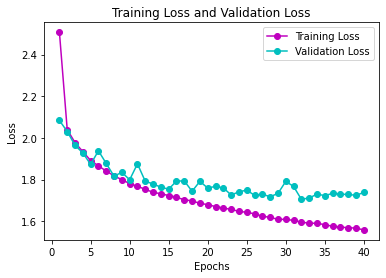

In [60]:
plotLoss(model3L1Result.history['loss'], model3L1Result.history['val_loss'])

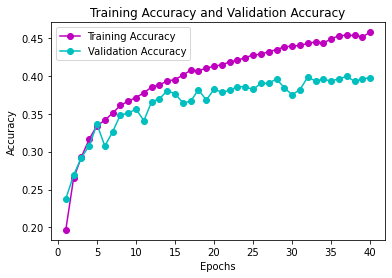

In [61]:
plotAccuracy(model3L1Result.history['accuracy'], model3L1Result.history['val_accuracy'])

In [62]:
test_loss3L1, test_acc3L1 = model3L1.evaluate(x_val, y_val)
print('Test accuracy:', round(test_acc3L1*100,2), "%")

375/375 [==============================] - 1s 3ms/step - loss: 1.7552 - accuracy: 0.3993
Test accuracy: 39.93 %


#### Adding L2 Regularization first, then L1 Regularization

In [63]:
model3L2 = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(1024,)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [64]:
model3L2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [65]:
model3L2Result = model3L2.fit(x_train, y_train, epochs=40, batch_size=32,
                    validation_split=0.2)

Epoch 1/40
900/900 [==============================] - 13s 12ms/step - loss: 2.3873 - accuracy: 0.2072 - val_loss: 2.0665 - val_accuracy: 0.2601
Epoch 2/40
900/900 [==============================] - 11s 12ms/step - loss: 2.0222 - accuracy: 0.2815 - val_loss: 1.9670 - val_accuracy: 0.2989
Epoch 3/40
900/900 [==============================] - 11s 13ms/step - loss: 1.9445 - accuracy: 0.3086 - val_loss: 1.9065 - val_accuracy: 0.3196
Epoch 4/40
900/900 [==============================] - 11s 13ms/step - loss: 1.8959 - accuracy: 0.3265 - val_loss: 1.9309 - val_accuracy: 0.3132
Epoch 5/40
900/900 [==============================] - 11s 12ms/step - loss: 1.8608 - accuracy: 0.3435 - val_loss: 1.8480 - val_accuracy: 0.3386
Epoch 6/40
900/900 [==============================] - 11s 12ms/step - loss: 1.8312 - accuracy: 0.3551 - val_loss: 1.8287 - val_accuracy: 0.3451
Epoch 7/40
900/900 [==============================] - 11s 12ms/step - loss: 1.8042 - accuracy: 0.3634 - val_loss: 1.8288 - val_accuracy:

In [66]:
model3L2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 512)               524800    
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                                 
 dense_29 (Dense)            (None, 128)               32896     
                                                                 
 dense_30 (Dense)            (None, 64)                8256      
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 dense_32 (Dense)            (None, 10)                330       
                                                                 
Total params: 699,690
Trainable params: 699,690
Non-tr

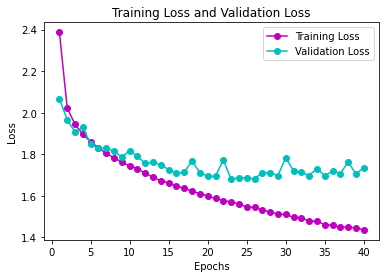

In [67]:
plotLoss(model3L2Result.history['loss'], model3L2Result.history['val_loss'])

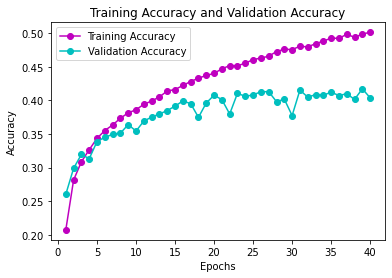

In [68]:
plotAccuracy(model3L2Result.history['accuracy'], model3L2Result.history['val_accuracy'])

In [69]:
test_loss3L2, test_acc3L2 = model3L2.evaluate(x_val, y_val)
print('Test accuracy:', round(test_acc3L2*100,2), "%")

375/375 [==============================] - 1s 3ms/step - loss: 1.7525 - accuracy: 0.4080
Test accuracy: 40.8 %


#### Adding regularization functions vs under and overfitted models

The model was first tested with L1 Regularization before L2 Regularization, but the results were better if L2 Regularization was applied before L1 Regularization. Different regularization percentages was also experimented with, and 0.001 produced the best results.

The new models with regularization functions has both performed better than the underfitted model at 38.87% and the overfitted model at 38.26%. 

The model with L1 then L2 Regularization has seen improvements at 39.93% accuracy, while the model with L2 then L1 Regularization has a 40.8% accuracy. 

This shows that adding the regularization functions does help improve the model, and more experiment can be carried out to find the optimal regularization percentage.

### Method 4: Adjusting the number of epochs

Having a smaller number of epoch can help prevent the model from learning too much training data and fitting itself to the data. A smaller number of epoch means less time to learn the noise and the random patterns in the training data. However, too little epochs and the model would not be able to capture any underlying patterns in the data.

Increasing the number of epochs can help the model interact more with the data and potentially learn more patterns. This allows the model to have a greater sample to identify underlying patterns across the different data. However, too many epochs and it will lead to overfitting,

Experiment must be carried out to find the optimal layer of epochs, and a good way to monitor would be to analyze the validation loss of the model.

#### Increasing epoch size to 60 instead of 40

In [70]:
model4E60 = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(1024,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [71]:
model4E60.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [72]:
model4E60Result = model4E60.fit(x_train, y_train, epochs=60, batch_size=32,
                    validation_split=0.2)

Epoch 1/60
900/900 [==============================] - 11s 11ms/step - loss: 2.1207 - accuracy: 0.2104 - val_loss: 2.0048 - val_accuracy: 0.2775
Epoch 2/60
900/900 [==============================] - 10s 11ms/step - loss: 1.9648 - accuracy: 0.2907 - val_loss: 1.9374 - val_accuracy: 0.2986
Epoch 3/60
900/900 [==============================] - 10s 11ms/step - loss: 1.8962 - accuracy: 0.3215 - val_loss: 1.9074 - val_accuracy: 0.3142
Epoch 4/60
900/900 [==============================] - 10s 11ms/step - loss: 1.8475 - accuracy: 0.3388 - val_loss: 1.8379 - val_accuracy: 0.3406
Epoch 5/60
900/900 [==============================] - 10s 11ms/step - loss: 1.8128 - accuracy: 0.3523 - val_loss: 1.7982 - val_accuracy: 0.3424
Epoch 6/60
900/900 [==============================] - 10s 11ms/step - loss: 1.7798 - accuracy: 0.3623 - val_loss: 1.7905 - val_accuracy: 0.3533
Epoch 7/60
900/900 [==============================] - 10s 12ms/step - loss: 1.7487 - accuracy: 0.3786 - val_loss: 1.8041 - val_accuracy:

In [73]:
model4E60.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 512)               524800    
                                                                 
 dense_34 (Dense)            (None, 256)               131328    
                                                                 
 dense_35 (Dense)            (None, 128)               32896     
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 dense_37 (Dense)            (None, 32)                2080      
                                                                 
 dense_38 (Dense)            (None, 10)                330       
                                                                 
Total params: 699,690
Trainable params: 699,690
Non-tr

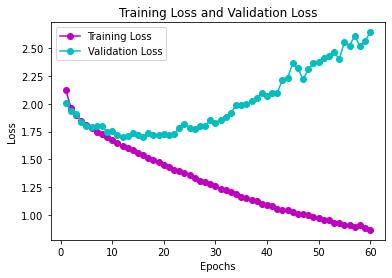

In [74]:
plotLoss(model4E60Result.history['loss'], model4E60Result.history['val_loss'])

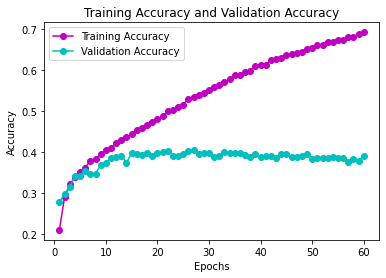

In [75]:
plotAccuracy(model4E60Result.history['accuracy'], model4E60Result.history['val_accuracy'])

In [76]:
test_loss4E60, test_acc4E60 = model4E60.evaluate(x_val, y_val)
print('Test accuracy:', round(test_acc4E60*100,2), "%")

375/375 [==============================] - 1s 3ms/step - loss: 2.6171 - accuracy: 0.3932
Test accuracy: 39.32 %


#### Epoch size 60 vs under and overfitted model at epoch size 40

Increasing the epoch size to 60 epochs has minimal improvement on the model, bringing the accuracy to 39.32%. The model has done worse than the underfitted model which had 38.87% accuracy, but done better than the overfitted model which had 38.26% accuracy. 

#### Decreasing epoch size to 20 instead of 40

In [77]:
model4E20 = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(1024,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [78]:
model4E20.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [79]:
model4E20Result = model4E20.fit(x_train, y_train, epochs=20, batch_size=32,
                    validation_split=0.2)

Epoch 1/20
900/900 [==============================] - 12s 12ms/step - loss: 2.1212 - accuracy: 0.2089 - val_loss: 2.0084 - val_accuracy: 0.2650
Epoch 2/20
900/900 [==============================] - 10s 11ms/step - loss: 1.9673 - accuracy: 0.2889 - val_loss: 1.8988 - val_accuracy: 0.3054
Epoch 3/20
900/900 [==============================] - 10s 12ms/step - loss: 1.8978 - accuracy: 0.3169 - val_loss: 1.8627 - val_accuracy: 0.3249
Epoch 4/20
900/900 [==============================] - 10s 11ms/step - loss: 1.8484 - accuracy: 0.3358 - val_loss: 1.8299 - val_accuracy: 0.3389
Epoch 5/20
900/900 [==============================] - 10s 11ms/step - loss: 1.8080 - accuracy: 0.3512 - val_loss: 1.8083 - val_accuracy: 0.3462
Epoch 6/20
900/900 [==============================] - 10s 11ms/step - loss: 1.7742 - accuracy: 0.3643 - val_loss: 1.8016 - val_accuracy: 0.3581
Epoch 7/20
900/900 [==============================] - 10s 12ms/step - loss: 1.7431 - accuracy: 0.3765 - val_loss: 1.8021 - val_accuracy:

In [80]:
model4E20.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 512)               524800    
                                                                 
 dense_40 (Dense)            (None, 256)               131328    
                                                                 
 dense_41 (Dense)            (None, 128)               32896     
                                                                 
 dense_42 (Dense)            (None, 64)                8256      
                                                                 
 dense_43 (Dense)            (None, 32)                2080      
                                                                 
 dense_44 (Dense)            (None, 10)                330       
                                                                 
Total params: 699,690
Trainable params: 699,690
Non-tr

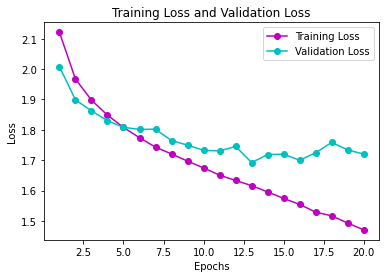

In [81]:
plotLoss(model4E20Result.history['loss'], model4E20Result.history['val_loss'])

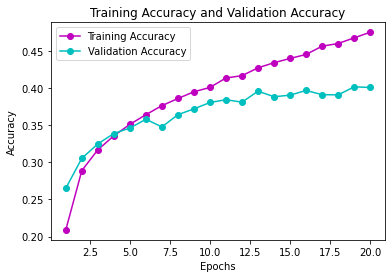

In [82]:
plotAccuracy(model4E20Result.history['accuracy'], model4E20Result.history['val_accuracy'])

In [83]:
test_loss4E20, test_acc4E20 = model4E20.evaluate(x_val, y_val)
print('Test accuracy:', round(test_acc4E20*100,2), "%")

375/375 [==============================] - 1s 4ms/step - loss: 1.7442 - accuracy: 0.4023
Test accuracy: 40.23 %


#### Epoch size 20 vs under and overfitted model at epoch size 40

Decreasing the epoch size to 20 epochs has seen improvement on the model, bringing the accuracy to 40.23%. The model has done better than both the underfitted model at 38.87% accuracy, and the overfitted model at 38.26% accuracy. 

This shows that reducing the epoch size does help reduce overfitting and helps improve model accuracy. The optimal epoch size can be found by experimenting with different values.

### Method 5: Increasing the batch size

Generally, having a larger batch size allows the model to train with a more representative sample of the overall training data, and this helps to smooth out any noise in the training data, which will help the model learn better and perform better on unseen data. 

However, too big a batch size may not be helpful and it may require more resources to train the model. Too small a batch size may lead to more fluctutations in the training process and cause the model too slowly.

In [84]:
model5 = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(1024,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [85]:
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [86]:
model5Result = model5.fit(x_train, y_train, epochs=40, batch_size=128,
                    validation_split=0.2)

Epoch 1/40
225/225 [==============================] - 5s 16ms/step - loss: 2.1257 - accuracy: 0.2191 - val_loss: 2.0431 - val_accuracy: 0.2625
Epoch 2/40
225/225 [==============================] - 3s 14ms/step - loss: 1.9626 - accuracy: 0.2922 - val_loss: 1.9091 - val_accuracy: 0.3088
Epoch 3/40
225/225 [==============================] - 3s 15ms/step - loss: 1.8914 - accuracy: 0.3220 - val_loss: 1.8786 - val_accuracy: 0.3231
Epoch 4/40
225/225 [==============================] - 3s 15ms/step - loss: 1.8418 - accuracy: 0.3420 - val_loss: 1.8403 - val_accuracy: 0.3354
Epoch 5/40
225/225 [==============================] - 3s 15ms/step - loss: 1.8011 - accuracy: 0.3569 - val_loss: 1.7954 - val_accuracy: 0.3544
Epoch 6/40
225/225 [==============================] - 4s 17ms/step - loss: 1.7658 - accuracy: 0.3703 - val_loss: 1.7672 - val_accuracy: 0.3603
Epoch 7/40
225/225 [==============================] - 4s 16ms/step - loss: 1.7387 - accuracy: 0.3768 - val_loss: 1.7551 - val_accuracy: 0.3751

In [87]:
model5.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 512)               524800    
                                                                 
 dense_46 (Dense)            (None, 256)               131328    
                                                                 
 dense_47 (Dense)            (None, 128)               32896     
                                                                 
 dense_48 (Dense)            (None, 64)                8256      
                                                                 
 dense_49 (Dense)            (None, 32)                2080      
                                                                 
 dense_50 (Dense)            (None, 10)                330       
                                                                 
Total params: 699,690
Trainable params: 699,690
Non-tr

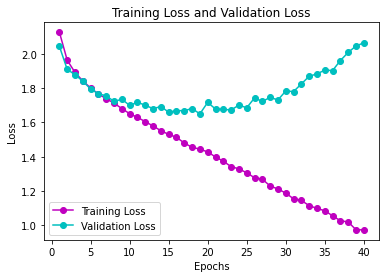

In [88]:
plotLoss(model5Result.history['loss'], model5Result.history['val_loss'])

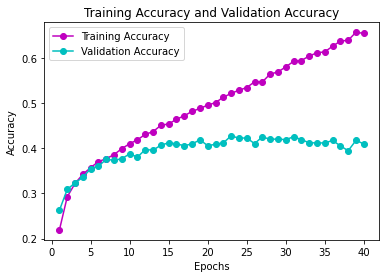

In [89]:
plotAccuracy(model5Result.history['accuracy'], model5Result.history['val_accuracy'])

In [90]:
test_loss5, test_acc5 = model5.evaluate(x_val, y_val)
print('Test accuracy:', round(test_acc5*100,2), "%")

375/375 [==============================] - 1s 3ms/step - loss: 2.0578 - accuracy: 0.4175
Test accuracy: 41.75 %


#### Batch size 128 vs under and overfitted models at batch size 32

After increasing the batch size from 32 to 128, we can see a large improvement to 41.75% accuracy as compared to 38.87% from the underfitted model, and 38.26% from the overfitted model. 

This shows that increasing the batch size helps significantly. The optimal batch size can be found through experimenting with different batch sizes.

### Combining all methods together

Now that we have developed the final model with the necessary adjustments, we will be training the model with both the training and validation set, which will be concatenated before being parsed into the model.

In [91]:
finalModel = models.Sequential([
    layers.Dense(512, activation='relu', input_shape=(1024,)),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.001)),
    layers.Dense(10, activation='softmax')
])

In [92]:
finalModel.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [93]:
finalModelResult = finalModel.fit(np.concatenate([x_train,x_val]), np.concatenate([y_train,y_val]), 
                                  epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
300/300 [==============================] - 6s 16ms/step - loss: 2.8386 - accuracy: 0.2379 - val_loss: 2.2298 - val_accuracy: 0.3027
Epoch 2/30
300/300 [==============================] - 5s 15ms/step - loss: 2.1291 - accuracy: 0.3025 - val_loss: 2.0208 - val_accuracy: 0.3270
Epoch 3/30
300/300 [==============================] - 5s 16ms/step - loss: 1.9960 - accuracy: 0.3265 - val_loss: 1.9650 - val_accuracy: 0.3297
Epoch 4/30
300/300 [==============================] - 5s 15ms/step - loss: 1.9386 - accuracy: 0.3409 - val_loss: 1.8862 - val_accuracy: 0.3570
Epoch 5/30
300/300 [==============================] - 4s 15ms/step - loss: 1.9004 - accuracy: 0.3547 - val_loss: 1.8829 - val_accuracy: 0.3569
Epoch 6/30
300/300 [==============================] - 5s 15ms/step - loss: 1.8681 - accuracy: 0.3638 - val_loss: 1.8419 - val_accuracy: 0.3761
Epoch 7/30
300/300 [==============================] - 4s 15ms/step - loss: 1.8396 - accuracy: 0.3715 - val_loss: 1.8245 - val_accuracy: 0.3753

In [94]:
finalModel.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_52 (Dense)            (None, 256)               131328    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_53 (Dense)            (None, 128)               32896     
                                                                 
 dense_54 (Dense)            (None, 10)                1290      
                                                                 
Total params: 690,314
Trainable params: 690,314
Non-tr

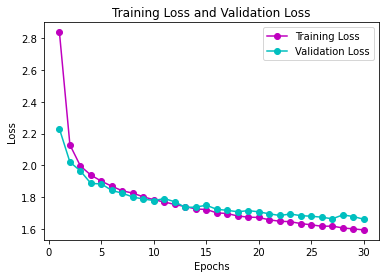

In [95]:
plotLoss(finalModelResult.history['loss'], finalModelResult.history['val_loss'])

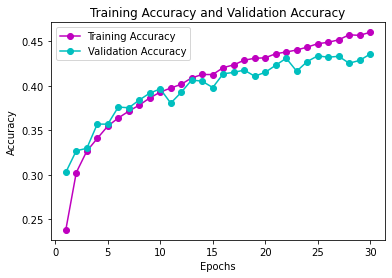

In [96]:
plotAccuracy(finalModelResult.history['accuracy'], finalModelResult.history['val_accuracy'])

In [97]:
test_lossF, test_accF = finalModel.evaluate(x_test, y_test)
print('Test accuracy:', round(test_accF*100,2), "%")

375/375 [==============================] - 2s 4ms/step - loss: 1.6751 - accuracy: 0.4307
Test accuracy: 43.07 %


#### New model vs baseline, under and overfitted model

Combining all the different methods from earlier and tweaking the number around has derived this current model, which brings us to 43.07% accuracy on the test data set. This is a huge improvement from the initial 38.266% on the overfitted model and 9.77% on the initial baseline model.

### Evaluation metrics

Different evaluaton metrics will be imported to calculate different rating scores, to gauge how effective the training model was.

In [98]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

In [99]:
# initializing the data arrays to be used in evaluation metrics
y_pred = finalModel.predict(x_test)
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

375/375 [==============================] - 1s 3ms/step


In [103]:
cm = confusion_matrix(y_test, y_pred)
ps = precision_score(y_test, y_pred, average='micro')
rs = recall_score(y_test, y_pred, average='micro')
f1s = f1_score(y_test, y_pred, average='micro')
cks = cohen_kappa_score(y_test, y_pred)

print("The Precision score is:", round(ps*100,2), "%")
print("The Recall score is:", round(rs*100,2), "%")
print("The F1 score is:", round(f1s*100,2), "%")
print("The Cohen Kappa score is:", round(cks*100,2), "%")

The Precision score is: 43.07 %
The Recall score is: 43.07 %
The F1 score is: 43.07 %
The Cohen Kappa score is: 36.75 %


Find below a visualization of the effectiveness of the model as shown in a confusion matrix, as well as a short snippet of prediction vs. actual results.

Text(69.0, 0.5, 'Actual')

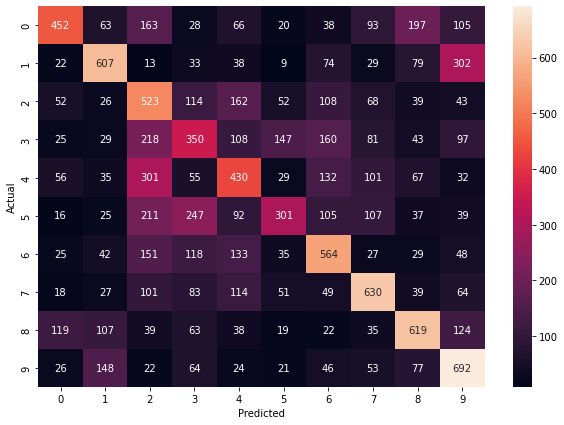

In [101]:
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")

In [102]:
print("First 10 predicted values:", y_pred[:10])
print("First 10 actual values:", y_test[:10])

First 10 predicted values: [9 3 9 9 6 3 6 7 3 9]
First 10 actual values: [9 3 9 9 6 2 6 7 9 7]


Printing the first 10 values in both the predicted set and the actual set shows that 7 out of 10 were correct, which is a 70% in this tiny subset.

### Analysis

From the evaluation metrics, the model has improved from before any adjustments are made, and is able to produce an accuracy result of 43.07%.

While the baseline model only achieved 9.77%, and the improved model only scored 38.26%, it can be concluded that the first two models did not perform well. 

Modifications were made to the model after a series of iterative modeling experimentation, including the addition of regularization techniques, and finding the right number of layers. Other experiments like dropout percentages, regularization percentages, and validation set sizes were also being carried out.

The changes made to achieve the final model are as follows:
1. Lesser number of layers from seven to four layers
2. Two dropout layers were added 
3. L2 and L1 Regularization techniques were added to two layers
4. Number of epochs decreased from 40 to 30
5. Batch size increased from 32 to 128

The final model achieved the highest accuracy score of 43.07%, demonstrating the efectiveness of the different methods to tune the hyperparameters to improve the model, as compared to the initial models. 

Overall, this project highlights the importance of fine-tuning deep learning models to achieve better results, especially on complex datasets like the CIFAR-10. 

### References

- cifar10. (n.d.). TensorFlow. https://www.tensorflow.org/datasets/catalog/cifar10 

- K. (2022, August 5). keras/cifar10.py at v2.11.0 · keras-team/keras. GitHub. 
https://github.com/keras-team/keras/blob/v2.11.0/keras/datasets/cifar10.py#L29-L115 

- Papers with Code - CIFAR-10 Dataset. (n.d.). https://paperswithcode.com/dataset/cifar-10 

- sklearn.preprocessing.OneHotEncoder. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder.fit 

- tf.keras.Model. (n.d.). TensorFlow. https://www.tensorflow.org/api_docs/python/tf/keras/Model

- two (or more) graphs in one plot with different x-axis AND y-axis scales in python. (n.d.). Stack Overflow. https://stackoverflow.com/questions/42734109/two-or-more-graphs-in-one-plot-with-different-x-axis-and-y-axis-scales-in-pyth